<a href="https://colab.research.google.com/github/NikV-JS/Reddit-Flair-Detector/blob/master/Notebooks/EDA(Part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 2 of the assignment is Exploratory Data Analysis and Pre-processing of the dataset for performing deep learning model training and validation.

In [0]:
# Installing the requirements for this notebook
!pip install -q numpy pandas nltk sklearn seaborn

In [0]:
# Importing the required modules
import numpy as np
import pandas as pd
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
import seaborn as sns
color = sns.color_palette()

eng_stopwords = set(stopwords.words("english"))

import matplotlib.pyplot as plt

In [0]:
# Loading the final dataset of size 6,000 obtained from Part 1 as Pandas DataFrame
Data = pd.read_csv('/content/Final_Dataset.csv')

In [0]:
# Printing the number of cases in each flair category of final dataset
flairs = list(set(Data['flair']))
for flair in flairs:
    print (flair,': ' , len(Data[Data['flair'] == flair]))

Science/Technology :  500
AskIndia :  714
Food :  500
Politics :  714
CAA-NRC-NPR :  109
Policy/Economy :  500
Business/Finance :  500
Sports :  500
Non-Political :  713
Coronavirus :  250
Scheduled :  500
Photography :  500


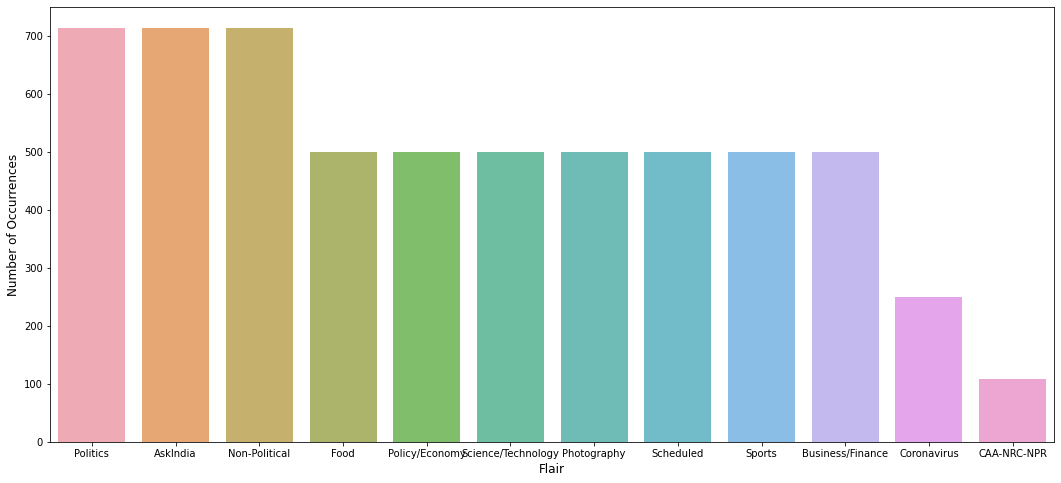

In [0]:
# Plotting Bar diagram indicating number of occurences vs Flair category for qualitative inference
count_flair = Data['flair'].value_counts()

plt.figure(figsize=(18,8))
sns.barplot(count_flair.index, count_flair.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Flair', fontsize=12)
plt.show()

The next step is to perform analysis on the data to get insights regarding the text data. The exploratory data analysis also helps in predicting the strengths and weakness of model because through observation of trends in the data it can be seen that which factors influence the model's generalization capability. The initial approach is to study the frequency of words appearing in 'Title' of submissions of a particular flair category. When implemented it was evident, as expected, that english stopwords and punctuations had a high frequency in the data. So, the approach was to clean the data for Analysis by removing the stopwords in nltk module and also punctuation marks. The following code block is used for refining data for analysis.

In [0]:
Analysis_Data = Data;
Analysis_Data['Analysis_Title'] = Analysis_Data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (eng_stopwords)]))
Analysis_Data['Analysis_Title'] = Analysis_Data['Analysis_Title'].str.replace('[^\w\s]','')

Plots of Frequency vs Top 10 occurring words in the respective flair category using Seaborn, Pandas and Matplotlib.

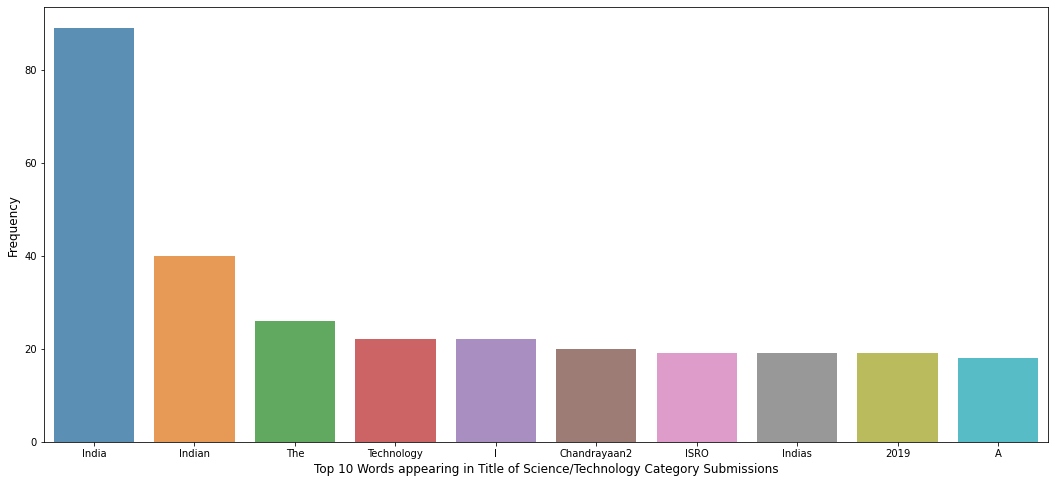

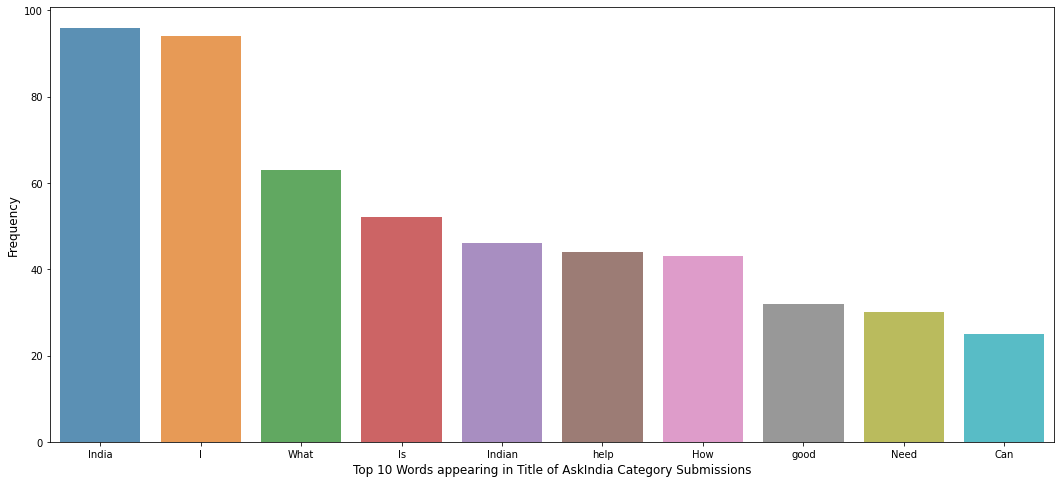

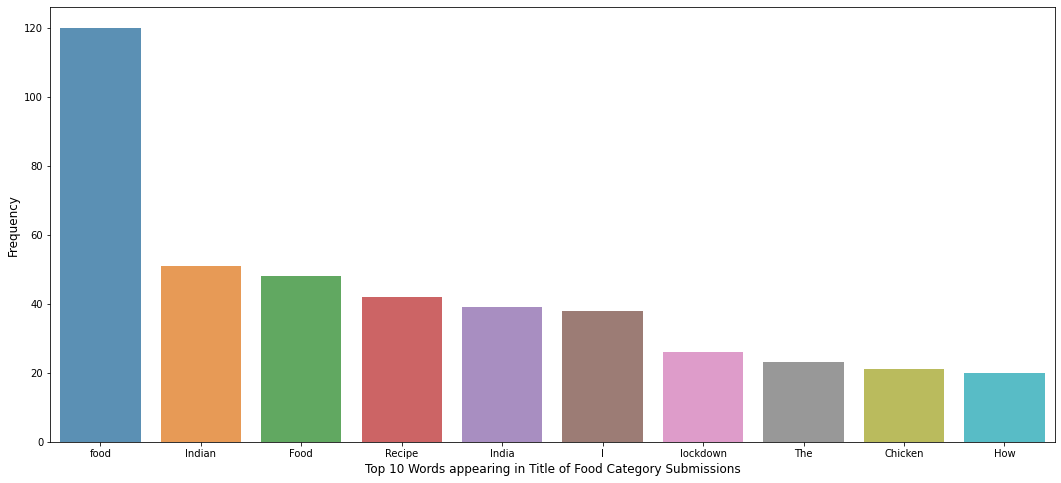

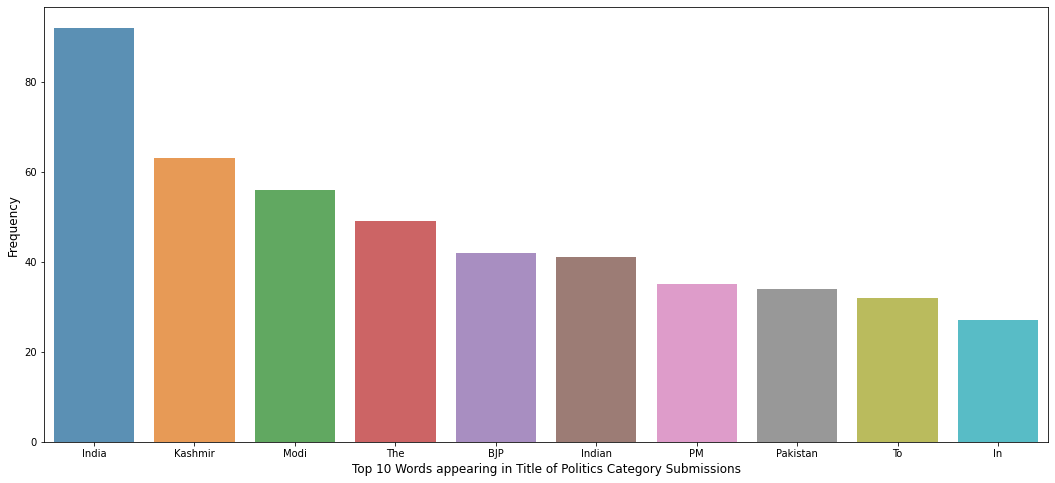

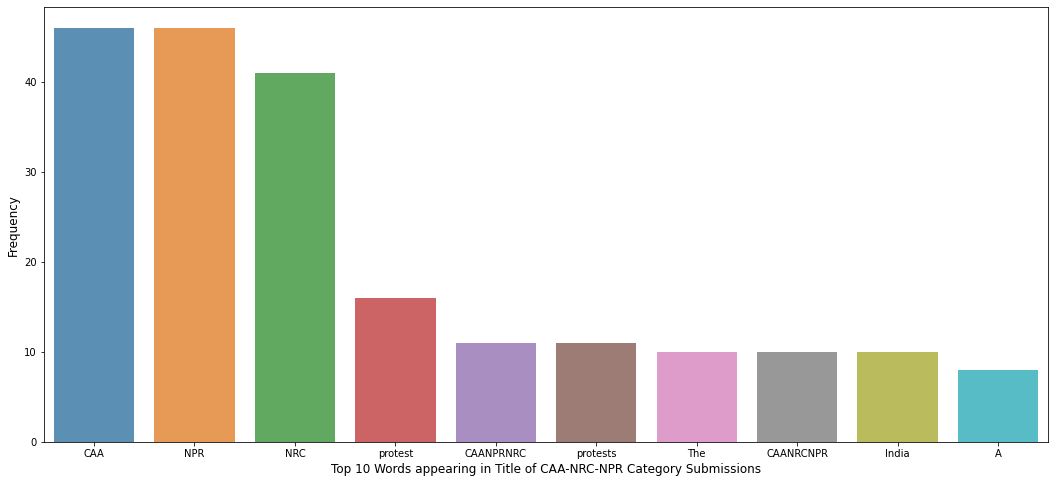

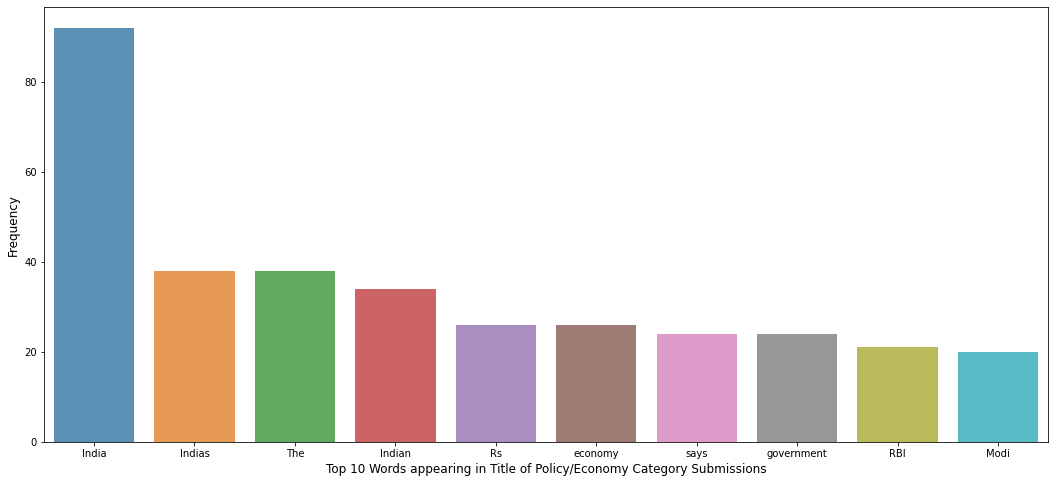

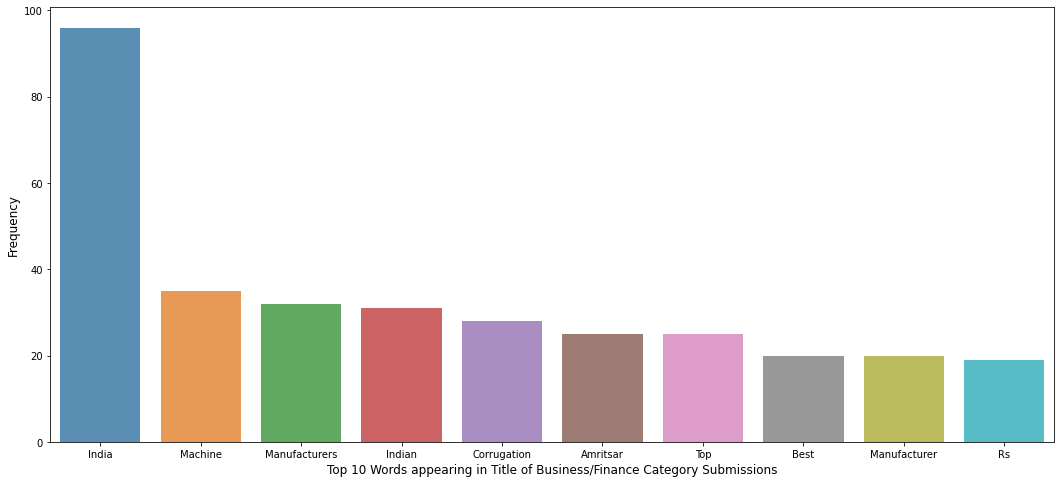

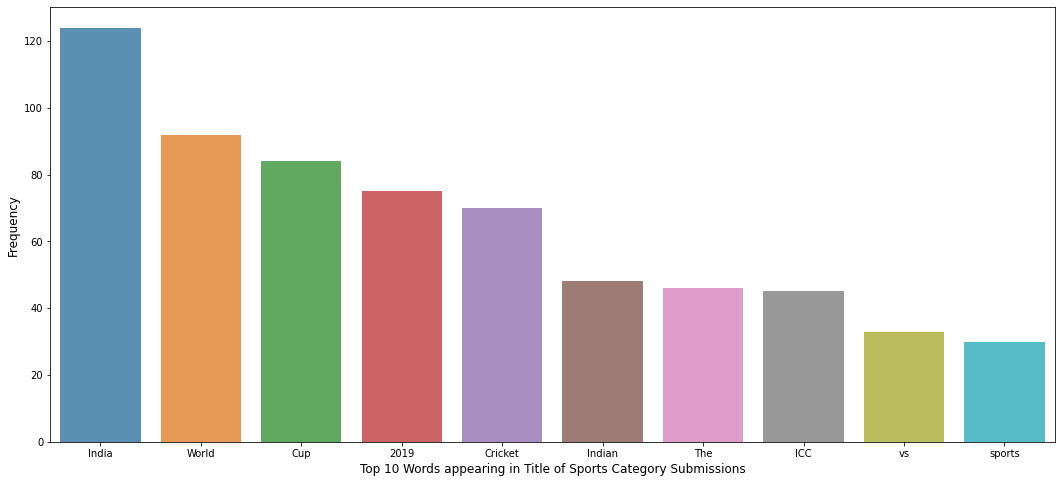

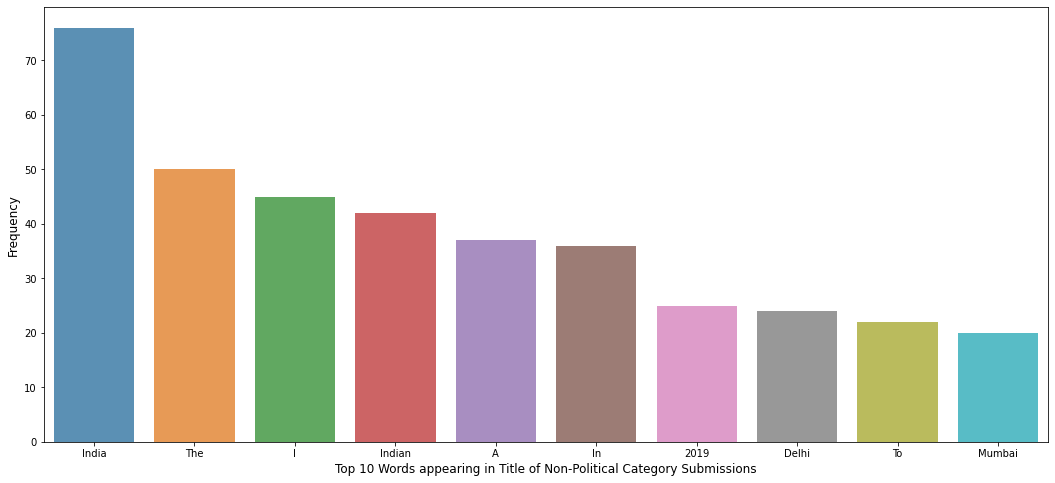

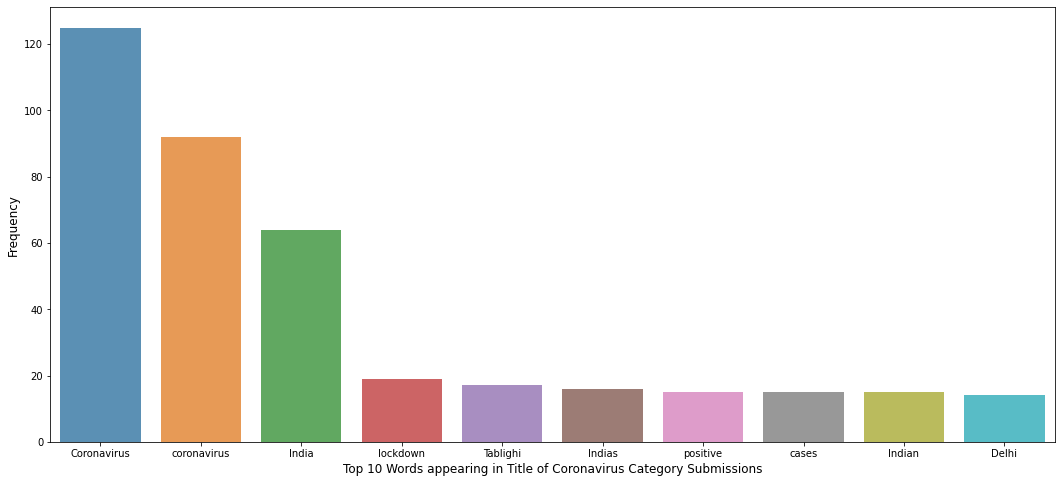

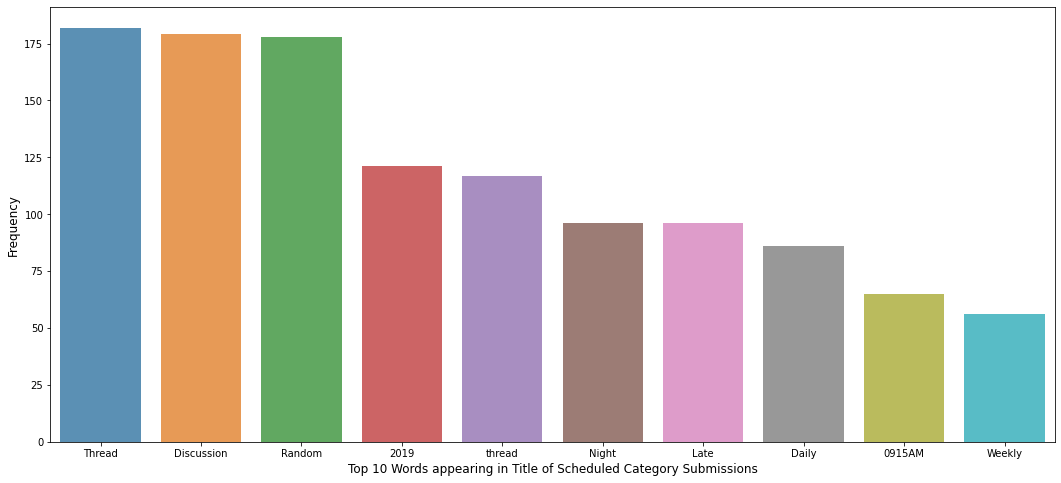

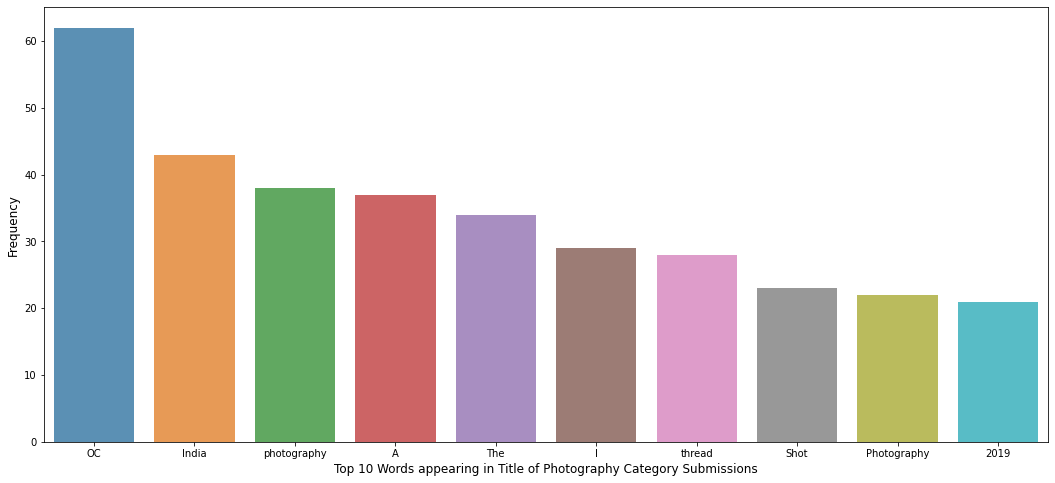

In [0]:
for i in range(0,12):
  Flair = Analysis_Data[Analysis_Data['flair'] == flairs[i]]
  Word_frequency = pd.Series(' '.join(Flair.Analysis_Title).split()).value_counts()[:10]

  plt.figure(figsize=(18,8))
  sns.barplot(Word_frequency.index, Word_frequency.values, alpha=0.8)
  plt.ylabel('Frequency', fontsize=12)
  plt.xlabel('Top 10 Words appearing in Title of '+str(flairs[i])+' Category Submissions', fontsize=12)
  plt.show()

A common trend which can be clearly observed from the above plots is that India is one of the most occurring words in each of the flair post titles. So it can be understood that the model should not generalize and classify based on the presence of word India. Another expected trend which can be observed is that in flair categories like 'Food', 'Coronavirus', 'Photography', and 'CAA-NRC-NPR' the names of the flair tend to be vastly present in the title thereby can be a ground basis for the model to classify the respective flairs. Also, another expected observation is that in 'AskIndia' (A Questions Forum) the words with frequency of occurrence are the common words, like how, showing up in questions. After a preliminary analysis of the trend of Reddit posts on the website it was quite clear that 'Scheduled' flair posts were of topics intersecting with other flairs but had a time scheduled to be posted or initimating time of discussions and so on. When observed, it can be seen that time and schedule related words tend to be more occurrant in 'Scheduled' Category. So the model might generalize based on this which can lead to good performance but hinder it's capability in detecting other flair category posts scheduled at a specific time. The top occurrences in 'Coronavirus' category are in line with current trend of news. One unexpected trend in the qualitative analysis is that the word 'lockdown' tends to be present majorly in the 'Food' flair posts. This indicates that the data present in the 'Food' category contains data majorly from the recently mined data using PRAW. Finally, the frequency distribution plotted above gives us a good perspective of the dataset and also gives us an insight into predicting the model's generalization capability.



Next step, will be to combine both the title and body of submission and perform a basic numerical analysis of various metafeatures. On observation of data it can be found that some posts have bodies which are deleted or no body is present. So firstly, the analysis data is cleaned up to remove 'nan', 'deleted' and 'removed' in body of submission.

In [0]:
empties = ['nan', '[deleted]', '[removed]']
Analysis_Data['body'] = Analysis_Data['body'].apply(lambda x: '' if x in empties else x)

For the Reddit Flair Detection, the title combined with body is used as the primary feature. So the following numerical analysis is done according to the combination of title and body.

In [0]:
Analysis_Data['Text'] = Analysis_Data['title'] + ' ' + Analysis_Data['body']

In this approach, the data will not be pre-processed to remove stopwords and punctuations as they usually tend to contribute to the performance of deep learning models. The following code is used to normalize the data through soft pre-processing.

In [0]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    if not isinstance(s, float):
      s = unicodeToAscii(s.lower().strip())
      s = re.sub(r"([.!?])", r" \1", s)
      s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [0]:
Analysis_Data['Text'] = Analysis_Data['Text'].apply(lambda x: normalizeString(x))

The following code is used to obtain the following metafeatures: 'Num_words', 'Num_unique_words', 'Num_chars', 'Num_stopwords', 'Num_punctuations', 'Num_words_upper', 'Num_words_title', 'Mean_word_len'.

In [0]:
Analysis_Data["num_words"] = Analysis_Data['Text'].apply(lambda x: len(str(x).split()))

Analysis_Data["num_unique_words"] = Analysis_Data['Text'].apply(lambda x: len(set(str(x).split())))

Analysis_Data["num_chars"] = Analysis_Data['Text'].apply(lambda x: len(str(x)))

Analysis_Data["num_stopwords"] = Analysis_Data['Text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

Analysis_Data["num_punctuations"] = Analysis_Data['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

Analysis_Data["num_words_upper"] = Analysis_Data['Text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

Analysis_Data["num_words_title"] = Analysis_Data['title'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

Analysis_Data["mean_word_len"] = Analysis_Data['Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Next, pandas DataFrame function describe( ) is used to obtain a statistical inference of the various metafeatures.

In [0]:
Analysis_Data.describe()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.0,6000.00000,5999.000000
mean,63.877167,31.516000,341.687000,26.260167,4.388333,0.0,4.02350,3.560228
std,258.012853,90.887539,1425.742797,109.954297,17.614726,0.0,3.26053,0.867621
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.00000,1.000000
25%,1.000000,1.000000,3.000000,0.000000,0.000000,0.0,2.00000,3.000000
50%,1.000000,1.000000,3.000000,0.000000,0.000000,0.0,3.00000,3.000000
75%,21.000000,19.000000,102.000000,8.000000,1.000000,0.0,5.00000,4.076118
max,6687.000000,1687.000000,39101.000000,2792.000000,343.000000,0.0,24.00000,11.000000


In the above table we can observe the various statistical elements such as mean, standard deviation, different percentiles for the different meta_features. The above table helps us gauge various aspects of the data and also is a potential indicator of model performance. As known, a deep learning model performance is based on the data used to train it, so here the mean number of words can give us a general idea of model performance on various sequence lengths. Below histograms of Number of words and unique words are plotted for qualitative inference. It can be observed that most of the posts have number of words between 0 to 180 and unique words between 0 to 100. Thus, this concludes the exploratory data analysis.

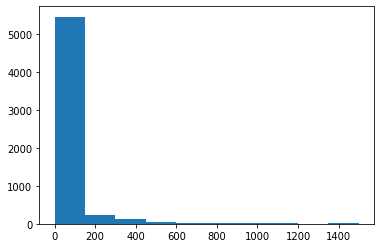

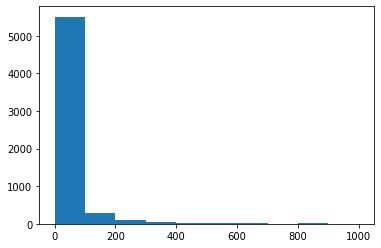

In [0]:
plt.hist(Analysis_Data['num_words'],range=(0,1500))
plt.show()
plt.hist(Analysis_Data['num_unique_words'],range=(0,1000))
plt.show()

In [0]:
Analysis_Data.to_csv('Analysis_Data.csv', index = False)

**Pre-Processing**

In [0]:
Data = pd.read_csv('/content/Final_Dataset.csv')

Checking if the body of submissions contains 'NAN', 'deleted', 'removed'.

In [0]:
Data['body'] = Data['body'].astype(str)

empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(Data[Data['body'] == empty]))

nan 3650
[deleted] 593
[removed] 296


Replacing removed, NaN, deleted with an empty character.

In [0]:
Data['body'] = Data['body'].apply(lambda x: '' if x in empties else x)

Verification of removal of NaN, [removed], [deleted] from the body of submission.

In [0]:
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
  print(empty, len(Data[Data['body'] == empty]))

nan 0
[deleted] 0
[removed] 0


Combining the Title with Body as a single feature.

In [0]:
Data['Text'] = Data['title'] + ' ' + Data['body']
Data['Text'] = Data['Text'].apply(lambda x: normalizeString(x))

In [0]:
Data = Data[['flair', 'Text']]

Now, the Dataset needs to be split as a part of pre-processing for the deep learning model training and testing. Following the famous and reliable Andrew Ng approach, the dataset was split into three subsets namely train, validation and test sets. The intuition behind following this approach is that it makes the test set anonymous to the deep learning model as it is not involved in any part of the model training and validation. Thereby allowing us to gauge the real world performance of model thorugh testing on the test set. An important aspect of this approach is that the validation and test set should have a similar distribution because during model training the validation accuracy helps us estimate final test accuracy.

In [0]:
#This code block produces different subsets each time it runs.
x, x_test, y, y_test = train_test_split(Data.Text,Data.flair,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [0]:
Train_Data = pd.merge(x_train, y_train, left_index=True, right_index=True)
Val_Data = pd.merge(x_val, y_val, left_index=True, right_index=True)
Test_Data = pd.merge(x_test, y_test, left_index=True, right_index=True)

Verification of Distribution of Test, Validation and Test set is done below by plotting the number of occurences. It is important that the validation and test set have a similar distribution of data. If they have a similar distribution the validation accuracy then can be an indicator of the final test accuracy that can be achieved by the deep learning model on the test set.

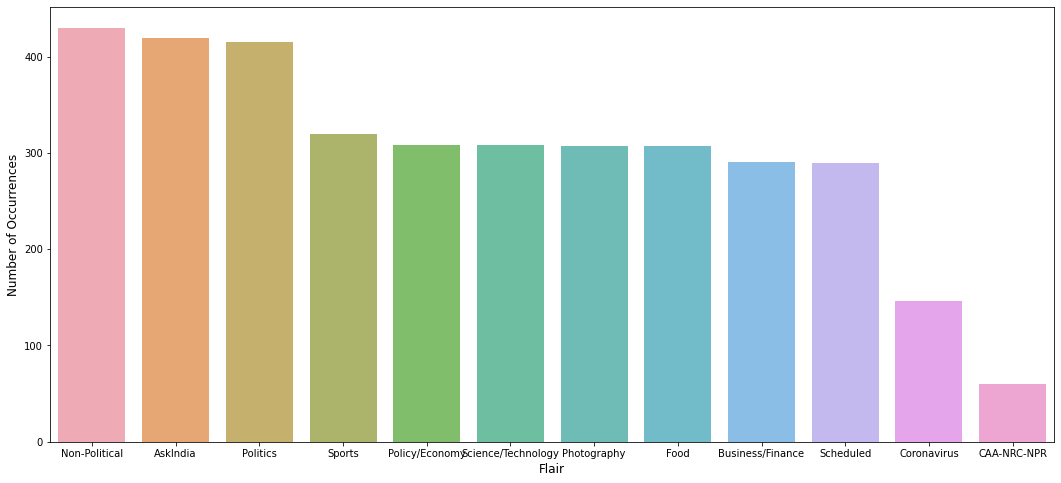

In [0]:
Train_flair = Train_Data['flair'].value_counts()

plt.figure(figsize=(18,8))
sns.barplot(Train_flair.index, Train_flair.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Flair', fontsize=12)
plt.show()

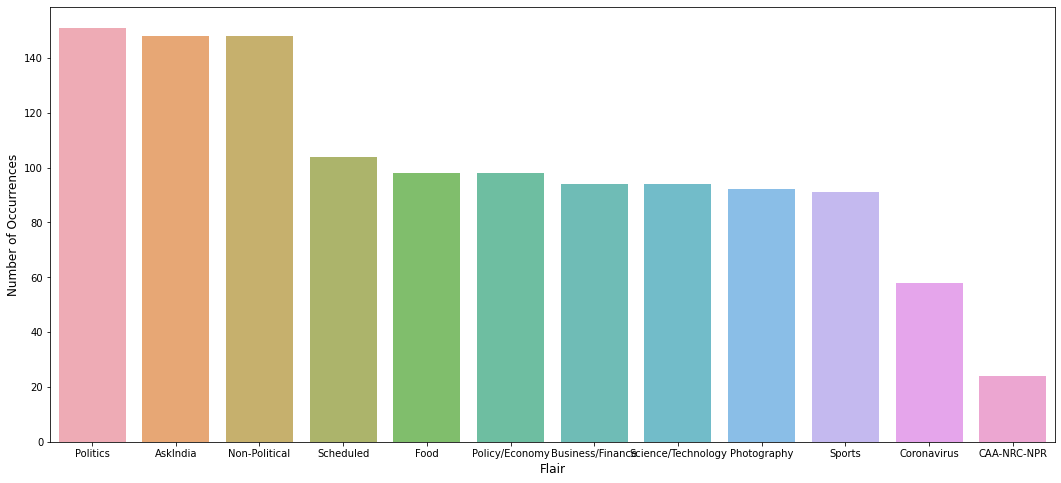

In [0]:
Val_flair = Val_Data['flair'].value_counts()

plt.figure(figsize=(18,8))
sns.barplot(Val_flair.index, Val_flair.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Flair', fontsize=12)
plt.show()

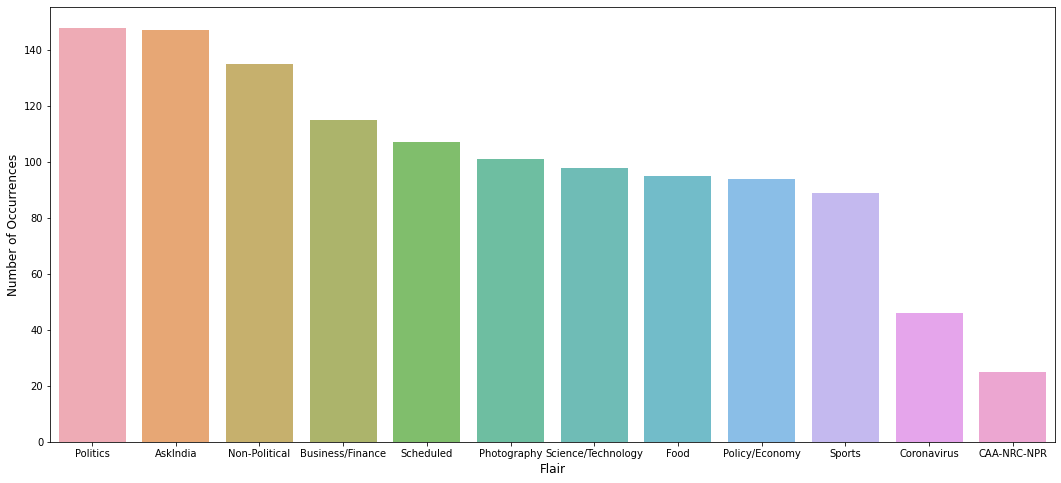

In [0]:
Test_flair = Test_Data['flair'].value_counts()

plt.figure(figsize=(18,8))
sns.barplot(Test_flair.index, Test_flair.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Flair', fontsize=12)
plt.show()

Now will save the Train, Val, Test data so that it can be used in Part-3 for deep learning model (XLNet) training and analysis of classification results.

In [0]:
Train_Data.to_csv('Train_Data.csv', index=False)
Val_Data.to_csv('Val_Data.csv', index=False)
Test_Data.to_csv('Test_Data.csv', index=False)